Loading Data

In [0]:
import pandas as pd
import numpy as np
from keras.models import load_model

links = pd.read_csv('gdrive/My Drive/links.csv')
movies = pd.read_csv('gdrive/My Drive/movies.csv')
ratings = pd.read_csv('gdrive/My Drive/ratings.csv')
tags = pd.read_csv('gdrive/My Drive/tags.csv')

Cleaning genres string. Replacing "|" with " " and replacing null with blank string.

In [0]:
tags_1 = pd.DataFrame(tags.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
df = pd.merge(movies, tags_1,on='movieId', how='left')
df['genres'] = df['genres'].str.replace('|',' ')
df.fillna("",inplace=True)

Label Encoding "movieId" column so that the movieId's start with 1 and end with 9742 (max number of movies in the dataset).



In [0]:
from sklearn.preprocessing import LabelEncoder
item_enc = LabelEncoder()

df['movieId'] = item_enc.fit_transform(df['movieId'].values)

df['movieId'] = df['movieId']+1

Converting upper case characters to lower case. To avoid duplicates when the words are tokenized.

In [0]:
df.genres = df.genres.apply(lambda x: x.lower())

In [0]:
import string
df.genres = df.genres.apply(lambda x: x.translate(string.punctuation))
df.tag = df.tag.apply(lambda x: x.translate(string.digits))

In [0]:
ratings['movieId'] = item_enc.fit_transform(ratings['movieId'].values)

ratings['movieId'] = ratings['movieId']+1


Grouping movies by userId.



In [0]:
user_movies_watched = pd.DataFrame(ratings.groupby(['userId']).apply(lambda x: [list(x['movieId'])]).apply(pd.Series))

Grouping movies by Genres.

In [0]:
genre_classes = pd.DataFrame(df.groupby(['genres']).apply(lambda x: [list(x['movieId'])]).apply(pd.Series)).reset_index()

In [0]:
genre_classes.columns = ['genres','movieId']

Adding a new column which will now represent the unique genre strings.

In [14]:
genre_classes_column = [int(i) for i in range(1,952)]
genre_classes['genres_class'] = np.array(genre_classes_column)
genre_classes

,genres,movieId,genres_class
0,(no genres listed),"[8518, 8685, 8688, 8783, 8837, 8903, 9034, 905...",1
1,action,"[9, 64, 173, 216, 556, 877, 1144, 1202, 1648, ...",2
2,action adventure,"[575, 607, 637, 802, 901, 991, 1209, 1368, 161...",3
3,action adventure animation,"[6926, 7923, 7924, 7925, 7926, 7942, 7943, 795...",4
4,action adventure animation children,"[7902, 7903, 7905, 7907, 8345, 9709]",5
...,...,...,...
946,sci-fi thriller,"[669, 1321, 2599, 2935, 3618, 3671, 3943, 5361...",947
947,sci-fi thriller imax,[7688],948
948,thriller,"[113, 162, 207, 332, 367, 399, 428, 474, 553, ...",949
949,war,"[2006, 2007, 4388, 6787]",950


Adding a new column to the main dataframe, which will now hold the tokenized genres.

In [0]:
genre_classes_column = [i for i in range(1,952)]
genre_classes['genres_class'] = np.array(genre_classes_column)

genre_dict = pd.Series(genre_classes.genres_class.values,index=genre_classes.genres).to_dict()
df_gen = df.genres.values
df_gen=[genre_dict[i] for i in df_gen]
df['genres_class'] = np.array(df_gen)

In [18]:
df.head(3)

,movieId,title,genres,tag,genres_class
0,1,Toy Story (1995),adventure animation children comedy fantasy,pixar pixar fun,352
1,2,Jumanji (1995),adventure children fantasy,fantasy magic board game robin williams game,418
2,3,Grumpier Old Men (1995),comedy romance,moldy old,733


Now, coming back to the grouped movies.

In [19]:
user_movies_watched.head(3)

,0
userId,
1,"[1, 3, 6, 44, 47, 63, 90, 98, 125, 131, 137, 1..."
2,"[278, 292, 1284, 2671, 4608, 5295, 6237, 6299,..."
3,"[31, 462, 546, 566, 586, 657, 697, 832, 853, 9..."


In [0]:
user_movies_watched.columns = ['movies']

Obtaining a single long list which has all the movies seen by every user.



In [0]:
movies_all = user_movies_watched.movies.values
movies_all = [item for sublist in movies_all for item in sublist]

In [0]:
# best to have a sequence size of 36: as 100836/36 is divisible

Will be creating a sequence of 36 movies (which will be our movie Input)

In [0]:
maxlen = 36 
step = 36
movies_list = []
for i in range(0, len(movies_all), step):
    movies_list.append(movies_all[i: i + maxlen])

In [24]:
len(movies_list)

2801

Obtain corresponding genre tokens.

In [0]:
master_genre = []
for i in movies_list:
    for j in i:
        hi = int(df.genres_class[df.movieId==j])
        master_genre.append(hi)
    

Will be creating a sequence of 36 genres (which will be our genre Input)

In [0]:
maxlen = 36 
step = 36
genres_list = []
for i in range(0, len(master_genre), step):
    genres_list.append(master_genre[i: i + maxlen])

In [0]:
gen_size = max(master_genre)
movies_size = max(movies_all)

Converting to float32 format, which is better suited for LSTM models compared to int.

In [0]:
x_mov = np.asarray(movies_list).astype('float32')
x_gen = np.asarray(genres_list).astype('float32')

In [29]:
x_gen[55]

array([882., 710., 635., 813., 877., 183., 611., 221., 923., 635., 617.,
       939., 666., 635., 774., 733., 733., 949., 874., 748., 748., 128.,
       671., 855., 722., 688., 517., 617., 813., 635., 866., 683., 683.,
       596., 869.,  26.], dtype=float32)

One hot encoded outputs corresponding the movie inputs.

In [0]:
y = np.zeros((2801, 9743),dtype=np.bool)
def y_s(j,row):
    for i in row:
        y[j,i]=1

for i in range(0,2801):
    y_s(i,movies_list[i])

In [31]:
y[0]

array([False,  True, False, ..., False, False, False])

The deep learning model.



In [0]:

import keras
from keras.layers import Concatenate, Dense, Dropout, Flatten, LSTM
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda
from keras.layers import Bidirectional

def rec(n_factors):
    
    movies = Input(shape=(36,))
    m = Embedding(movies_size+1, 256)(movies)
    m = Flatten()(m)
    
    genres = Input(shape=(36,))
    g = Embedding(gen_size+1, 256)(genres)
    g = Flatten()(g)
    
    x = Concatenate()([m, g])
    x = Reshape((1,18432))(x)
    x = LSTM(256, return_sequences=False) (x)
    x = Dropout(0.2)(x)
    x = Activation('relu')(x)
    x = Dense(9743)(x)
    x = Activation('softmax')(x)
    
    model = Model(inputs=[movies, genres], outputs=x)
    opt = keras.optimizers.RMSprop(lr=0.01)
    model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])
    return model


In [380]:
from keras.callbacks import EarlyStopping

model = rec(50)
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           (None, 36)           0                                            
__________________________________________________________________________________________________
input_41 (InputLayer)           (None, 36)           0                                            
__________________________________________________________________________________________________
embedding_40 (Embedding)        (None, 36, 256)      2489600     input_40[0][0]                   
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, 36, 256)      243712      input_41[0][0]                   
___________________________________________________________________________________________

Early Stopping to avoid overfitting.

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

Train/fit the model.

In [ ]:
#1000
history = model.fit(x=[x_mov, x_gen], y=y, batch_size=16, epochs=1000, verbose=1, validation_split=0.001, callbacks=[es])

Loss over time, looks good.

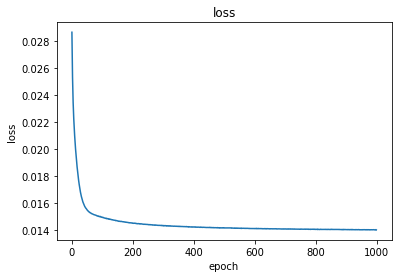

In [68]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

To prepare custom inputs which will be fed to our model.

In [0]:
def prepare_inputs(movie_input):
    """
    With only MovieID's as the input to our model, we are required to 
    obtain the required genre's and tag's and bring our raw input to
    the required shape.
    """
    
    movie_input = [DF.movieId[DF['title']==i].iloc[0] for i in movie_input]
    movies_copy = movie_input[:]

    genres = (DF.genres_class[DF["movieId"].isin(movie_input)].values).tolist()

    genres = pad(genres, INPUT_LENGTH["genre_len"])    
    movie_input = pad(movie_input, INPUT_LENGTH["movie_len"])
    
    return movie_input, genres, movies_copy

predict.

In [0]:
p = model.predict([np.array([movie_input,]),np.array([g_input,])])

Results.

In [407]:
def result(movie_copy, most_similar):
    """
    From the prediction indices, the corresponding movies are extracted 
    from the dataset.
    Also the original "watched" movie information is obtained.
    We return two dataframes: Watched and the Recommendations.
    """

    rec_movies = DF.set_index("movieId").loc[most_similar].reset_index()
    rec_movies = rec_movies.iloc[:,:-1]
    rec_movies = rec_movies[~rec_movies["movieId"].isin(movie_copy)]
    watched_movies = DF.set_index("movieId").loc[movie_copy].reset_index()
    watched_movies = watched_movies.iloc[:,1:]
    return watched_movies, rec_movies

,movieId,Title,Genres,Tags,genres_class
0,1044,Nightwatch (1997),horror thriller,,923
1,990,Some Kind of Wonderful (1987),drama romance,,869
2,1002,"Man Who Would Be King, The (1975)",adventure drama,india,466
3,816,Willy Wonka & the Chocolate Factory (1971),children comedy fantasy musical,,605
4,886,Hear My Song (1991),comedy,,635
5,836,Sophie's Choice (1982),drama,holocaust,813
6,969,Arsenic and Old Lace (1944),comedy mystery thriller,murder,732
7,839,Days of Thunder (1990),action drama romance,,279
8,900,"Princess Bride, The (1987)",action adventure comedy fantasy romance,inigo montoya six-fingered man,67
9,958,"Shining, The (1980)",horror,atmospheric disturbing horror jack nicholson m...,911
